In [ ]:
import os
import os.path
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
import torch.nn as nn
from torch import linalg as LA
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad as torch_grad
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import pickle
import shutil
from torchvision.utils import make_grid
import imageio
from google.colab import drive
drive.mount('/content/drive')
from matplotlib import cm


Mounted at /content/drive


# Model (Generator)

## Encoder

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
class ConvNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 2, stride = 1), 
        nn.ReLU(),
        nn.BatchNorm2d(64,momentum=0.9),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size = 3, stride = 1), 
        nn.ReLU(),
        nn.BatchNorm2d(128,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(128, 256, kernel_size = 2, stride = 1), 
        nn.ReLU(),
        nn.BatchNorm2d(256,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(256, 256, kernel_size = 2, stride = 1), 
        nn.ReLU(),
        nn.BatchNorm2d(256,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(256, 512, kernel_size = 3, stride = 1), 
        nn.ReLU(),
        nn.Dropout(0.2)
    )
  
  def forward(self, x):
    cnn_val = self.network(x)
    return_val = F.max_pool2d(cnn_val, kernel_size=cnn_val.size()[2:])
    return_val = torch.squeeze(return_val)
    return return_val

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.convNN = ConvNN()
    self.lstm = nn.LSTM(input_size = 512, hidden_size = 512,
                        batch_first = True, bidirectional = True,
                        num_layers = 4, dropout = 0.2)

  def forward(self, input):
    batch_size = int(input.shape[0]/img_length)
    
    in_features = self.convNN(input) 
    in_features = torch.reshape(in_features,(batch_size, img_length, 512))
    output, (h_n, c_n) = self.lstm(in_features)
    return h_n[-1]

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 512, out_channels = 256, 
                               kernel_size = 4, stride = 1, padding = 0, 
                               bias=False), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 128, 4, 2, 1, bias=False), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), 
            nn.Sigmoid()

        )
    def forward(self, input):
      return self.main(input)

# Discriminator (Critic)

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, img_size, dim):
      super(Discriminator, self).__init__()

      self.img_size = img_size

      self.image_to_features = nn.Sequential(
          nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(dim, 2 * dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(8 * dim, self.img_size[2], 4, 2, 1),
          nn.Sigmoid()
      )
      self.features_to_prob = nn.Sequential(
          nn.Linear(192, 1),
          nn.Sigmoid()
      )

  def forward(self, input_data):
    batch_size = input_data.size()[0]
    n_channels = input_data.size()[1]
    x = self.image_to_features(input_data)
    x = x.view(batch_size, -1)
    return self.features_to_prob(x)


# Models

In [ ]:
class CLSTM(nn.Module):
  def __init__(self, latent_dim):
    super(CLSTM, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.latent_dim = latent_dim
  def forward(self, x):
    y_hidden = self.encoder(x)  
    y_hidden = torch.unsqueeze(y_hidden,2)
    y_hidden = torch.unsqueeze(y_hidden,3)
    y_predict = self.decoder(y_hidden) 
    return y_predict
  def sample_latent(self, num_samples):
    return torch.randn((num_samples, self.latent_dim))

# Train

In [ ]:

class Trainer():

  def __init__(self, clstm, discriminator, gen_optimizer, dis_optimizer,train_mse,
               val_mse, train_g_loss,val_g_loss,train_d_loss,val_d_loss,
               checkpoint_path, best_model_path, save_model_every,valid_mse_min,
               print_every = 10, 
               use_cuda=True):
    self.G = clstm
    self.G_opt = gen_optimizer
    self.D = discriminator
    self.D_opt = dis_optimizer

    self.train_mse = train_mse
    self.val_mse = val_mse
    self.train_g_loss = train_g_loss
    self.val_g_loss = val_g_loss
    self.train_d_loss = train_d_loss
    self.val_d_loss = val_d_loss

    self.temp_train_d_loss = []
    self.temp_train_g_loss = []
    self.temp_val_d_loss = []
    self.temp_val_g_loss = []
    self.temp_train_mse = []
    self.temp_val_mse = []

    self.use_cuda = use_cuda

    self.checkpoint_path = checkpoint_path
    self.best_model_path = best_model_path

    self.print_every = print_every
    self.save_model_every = save_model_every
    self.valid_mse_min = valid_mse_min


    if self.use_cuda:
        self.G = self.G.cuda()
        self.D = self.D.cuda()
        
        
  def _critic_train_iteration(self, y_pred, y_true, train):
    # Get generated data
    batch_size = y_true.size()[0] 
    theoretical_real = torch.ones(batch_size,1)
    theoretical_fake = torch.zeros(batch_size,1)
    if self.use_cuda:
      theoretical_real = theoretical_real.cuda()
      theoretical_fake = theoretical_fake.cuda()

    # Calculate probabilities on real and generated data
    d_real = self.D(y_true)
    d_generated = self.D(y_pred)
    pixel_diff = adversarial_loss(y_true,y_pred)

    # Create total loss and optimize
    if train:
      # Get gradient penalty
      self.D_opt.zero_grad()
      d_real = d_real.view(batch_size, -1)
      d_generated = d_generated.view(batch_size,-1) 
      real_loss = adversarial_loss(d_real, theoretical_real)
      fake_loss = adversarial_loss(d_generated, theoretical_fake)
      d_loss = (1/2)* (real_loss + fake_loss) 

      d_loss.backward(retain_graph = True)
      self.D_opt.step()
      self.temp_train_d_loss.append(d_loss.data.cpu().numpy())
    else:
      d_real = d_real.view(batch_size, -1)
      d_generated = d_generated.view(batch_size,-1)
      real_loss = adversarial_loss(d_real, theoretical_real)
      fake_loss = adversarial_loss(d_generated, theoretical_fake)
      d_loss = (1/2)* (real_loss + fake_loss)
      self.temp_val_d_loss.append(d_loss.data.cpu().numpy())
  def _generator_train_iteration(self, y_pred, y_true, train):
    # Get generated data
    batch_size = y_true.size()[0]
    theoretical_real = torch.ones(batch_size,1)
    pixel_diff = adversarial_loss(y_true,y_pred)
    if self.use_cuda:
      theoretical_real = theoretical_real.cuda()
    if train:
      self.G_opt.zero_grad()
      # Calculate loss and optimize
      d_generated = self.D(y_pred)
      g_loss = 0.5*(adversarial_loss(d_generated,theoretical_real) + pixel_diff)
      g_loss.backward()
      self.G_opt.step()

      # Record loss
      g_loss = g_loss.data.cpu().numpy()
      self.temp_train_g_loss.append(g_loss)
      self.temp_train_mse.append(pixel_diff)
    else:
 
      # Calculate loss and optimize
      d_generated = self.D(y_pred)
      g_loss = 0.5*(adversarial_loss(d_generated, theoretical_real) + pixel_diff)

      # Record loss
      g_loss = g_loss.data.cpu().numpy()
      self.temp_val_g_loss.append(g_loss)
      self.temp_val_mse.append(pixel_diff)
  def _train_epoch(self,train_loader):

    for i, batch_train in enumerate(train_loader):
      
      x_train = batch_train[:,:-1,:,:,:]
      y_train = batch_train[:,-1,:,:,:]
      if self.use_cuda:
        x_train, y_train = x_train.cuda(), y_train.cuda()

      n_series = x_train.shape[0]
      n_img_in_series = x_train.shape[1]    
      img_channels = x_train.shape[2]
      img_height = x_train.shape[3]
      img_width = x_train.shape[4]

      x_train_new_dim = (n_series*n_img_in_series, img_channels, img_height, img_width)
      x_train = torch.reshape(x_train,x_train_new_dim)  
      y_train_predict = self.G(x_train)
      y_train_crop = fn.center_crop(y_train, output_size=[256])
      y_train_predict_crop = fn.center_crop(y_train_predict, output_size = [256])
      self._critic_train_iteration(y_train_predict_crop, y_train_crop, train = True)
      self._generator_train_iteration(y_train_predict_crop, y_train_crop, train = True)
  def _validate(self, val_loader):
    self.G.eval()
    with torch.no_grad():
      for batch_val in val_loader:
        x_val = batch_val[:,:-1,:,:,:]
        y_val = batch_val[:,-1,:,:,:]
        if self.use_cuda:
          x_val, y_val = x_val.cuda(), y_val.cuda()


        n_series_val = x_val.shape[0]
        n_img_in_series_val = x_val.shape[1]    
        img_channels_val = x_val.shape[2]
        img_height_val = x_val.shape[3]
        img_width_val = x_val.shape[4]

        x_val_new_dim = (n_series_val*n_img_in_series_val, img_channels_val, img_height_val, img_width_val)
        x_val = torch.reshape(x_val,x_val_new_dim)

        y_val_predict = self.G(x_val)
        y_val_crop = fn.center_crop(y_val, output_size=[256])
        y_val_predict_crop = fn.center_crop(y_val_predict, output_size = [256])
        self._critic_train_iteration(y_val_predict_crop, y_val_crop, train = False)
        self._generator_train_iteration(y_val_predict_crop, y_val_crop, train = False)
  def train(self, train_loader, start_epochs, n_epochs, validate_loader):
    for epoch in range(start_epochs, n_epochs):
      self.G.train()
      self._train_epoch(train_loader)
      self._validate(validate_loader)
      avg_train_g_loss = sum(self.temp_train_g_loss) / len(self.temp_train_g_loss)
      avg_train_d_loss = sum(self.temp_train_d_loss) / len(self.temp_train_d_loss)
      avg_val_g_loss = sum(self.temp_val_g_loss) / len(self.temp_val_g_loss)
      avg_val_d_loss = sum(self.temp_val_d_loss) / len(self.temp_val_d_loss)
      avg_train_mse = sum(self.temp_train_mse)/len(self.temp_train_mse)
      avg_val_mse = sum(self.temp_val_mse)/len(self.temp_val_mse)
      if epoch % self.print_every == 0:
        print("Iteration {}".format(epoch + 1))
        print("D: {}".format(avg_train_d_loss))
        print("val_D: {}".format(avg_val_d_loss))
        print("G: {}".format(avg_train_d_loss))
        print("val_G: {}".format(avg_val_g_loss))
        print("train_mse:{}".format(avg_train_mse))
        print("val_mse:{}".format(avg_val_mse))

      ##############
      # checkpoint #
      ##############

      if self.use_cuda:
        self.G, self.D = self.G.cpu(), self.D.cpu()
      self.train_g_loss.append(avg_train_g_loss)
      self.val_g_loss.append(avg_val_g_loss)
      self.train_d_loss.append(avg_train_d_loss)
      self.val_d_loss.append(avg_val_d_loss)
      self.train_mse.append(avg_train_mse)
      self.val_mse.append(avg_val_mse)

      curr_val_mse = self.val_mse[-1]
      if curr_val_mse <= self.valid_mse_min:
        new_valid_mse_min = curr_val_mse
      else:
        new_valid_mse_min = self.valid_mse_min
      checkpoint = {
        'epoch': epoch + 1,
        'generator_state_dict': self.G.state_dict(),
        'generator_optimizer': self.G_opt.state_dict(),
        'discriminator_state_dict': self.D.state_dict(),
        'discriminator_optimizer': self.D_opt.state_dict(),
        'train_mse': self.train_mse,
        'val_mse': self.val_mse,
        'train_g_loss':self.train_g_loss,
        'val_g_loss': self.val_g_loss,
        'train_d_loss':self.train_d_loss,
        'val_d_loss':self.val_d_loss,
        'lowest_val_loss': new_valid_mse_min
        }
      # save checkpoint
      save_ckp(checkpoint, False, self.checkpoint_path,self.best_model_path)
      if epoch % self.save_model_every == 0:
        backup_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/"+ "6_clstm_lsgan_"+str(epoch)+".pt"
        save_ckp(checkpoint,False , backup_path, self.best_model_path)
      # save another copy in case model corrupt
      if curr_val_mse <= self.valid_mse_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(self.valid_mse_min,curr_val_mse))
          # save checkpoint as best model
          save_ckp(checkpoint, True, self.checkpoint_path, self.best_model_path)
          self.valid_mse_min = curr_val_mse
      self.temp_train_d_loss = []
      self.temp_train_g_loss = []
      self.temp_val_d_loss = []
      self.temp_val_g_loss = []
      self.temp_train_mse = []
      self.temp_val_mse = []
      if self.use_cuda:
        self.G, self.D = self.G.cuda(), self.D.cuda()


# Checkpoint

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):

  f_path = checkpoint_path
  torch.save(state, f_path)
  if is_best:
      print("Saving a new best model")
      best_fpath = best_model_path
      # copy that checkpoint file to best path given, best_model_path
      shutil.copyfile(f_path, best_fpath)
  else:
    print('Validation does not improve')

In [ ]:
def load_ckp(checkpoint_fpath, gen_model, gen_opt, discrim_model, discrim_opt):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    device = torch.device("cuda")
    # load check point
    checkpoint = torch.load(checkpoint_fpath,map_location="cuda:0")
    # initialize state_dict from checkpoint to model
    gen_model.load_state_dict(checkpoint['generator_state_dict'])
    discrim_model.load_state_dict(checkpoint['discriminator_state_dict'])
    gen_model = gen_model.to(device)
    discrim_model = discrim_model.to(device)
    # initialize optimizer from checkpoint to optimizer
    gen_opt.load_state_dict(checkpoint['generator_optimizer'])
    discrim_opt.load_state_dict(checkpoint['discriminator_optimizer'])

    train_mse = checkpoint['train_mse']
    val_mse = checkpoint['val_mse']
    train_g_loss = checkpoint['train_g_loss']
    val_g_loss = checkpoint['val_g_loss']

    train_d_loss = checkpoint['train_d_loss']
    val_d_loss = checkpoint['val_d_loss']

    lowest_val_loss = checkpoint['lowest_val_loss']

    # return model, optimizer, epoch value, min validation loss 
    return checkpoint['epoch'], gen_model, discrim_model, gen_opt, discrim_opt, train_mse,val_mse,train_g_loss,val_g_loss,train_d_loss,val_d_loss,lowest_val_loss



# Setting Parameters

# Loading Datapoint

In [ ]:
# convert the image to array 
x_img_length = 2

x_arr = np.zeros(shape=(100,x_img_length, 3,288,432), dtype=np.uint8)
y_arr = np.zeros(shape=(100,1,3,288,432), dtype=np.uint8)

# series, how many image in a series, channel size, image width, image height

for i in range(100): # loop through 100 series
  for j in range(x_img_length): # loop through images within series
    model_path = "/content/drive/MyDrive/Capstone/Capstone_data_jpg/"+str(i)
    x_to_convert = Image.open(model_path+'/'+"{:02d}".format(j)+'im.jpg')
    x = np.asarray(x_to_convert)
    x = np.moveaxis(x,-1,0) # change image dimension to channel first
    x_arr[i][j] = x
  y_to_convert = Image.open(model_path+'/'+"{:02d}".format(x_img_length+1)+'im.jpg')
  y = np.asarray(y_to_convert)
  y = np.moveaxis(y,-1,0) # change image dimension to channel first
  y_arr[i][0] = y

# image dimention
n_series = x_arr.shape[0]
n_img_in_series = x_arr.shape[1]
img_channels = x_arr.shape[2]
img_height = x_arr.shape[3]
img_width = x_arr.shape[4]

# train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size = 0.2, random_state = 1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)

num_train_data = X_train.shape[0]
num_val_data = X_val.shape[0]
num_test_data = X_test.shape[0]

# generating means and std for normalization
trans_X_train= torch.tensor((np.array(X_train)/255).astype(np.float32))
trans_y_train = torch.tensor((np.array(y_train)/255).astype(np.float32))
trans_X_val = torch.tensor((np.array(X_val)/255).astype(np.float32))
trans_y_val = torch.tensor((np.array(y_val)/255).astype(np.float32))
trans_X_test = torch.tensor((np.array(X_test)/255).astype(np.float32))
trans_y_test = torch.tensor((np.array(y_test)/255).astype(np.float32))


# final train/val/test data 
final_train_data = torch.cat((trans_X_train, trans_y_train), dim = 1)
final_val_data = torch.cat((trans_X_val,trans_y_val),dim = 1)
final_test_data = torch.cat((trans_X_test,trans_y_test),dim = 1)

In [ ]:
batch_train_num = 8
batch_valid_num = 10
batch_test_num= 10

train_dl = DataLoader(final_train_data, batch_train_num, shuffle = True)
val_dl = DataLoader(final_val_data, batch_valid_num, shuffle = True)
test_dl = DataLoader(final_test_data, batch_test_num, shuffle = False)


# Calling Train

In [ ]:
# Train model
# setting parameters

img_length = x_img_length
clstm = CLSTM(512)
img_size = (288, 432, 3)
discriminator = Discriminator(img_size=img_size, dim=16)
print(clstm)
print(discriminator)

# Initialize optimizers
lr = 0.00001

adversarial_loss = torch.nn.MSELoss()
g_optimizer = optim.RMSprop(clstm.parameters(), lr = lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)
use_cuda = torch.cuda.is_available()

train_mse =[]
val_mse =[]
train_g_loss =[]
val_g_loss =[]
train_d_loss =[]
val_d_loss =[]
valid_mse_min = np.Inf
start_epochs = 0
n_epochs = 800
save_model_every = 100
checkpoint_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/6_clstm_lsgan_final.pt"
best_model_path = "/content/drive/MyDrive/Capstone/Capstone_models/6_clstm_lsgan_final.pt"


trainer = Trainer(clstm, discriminator, g_optimizer, d_optimizer, train_mse,
               val_mse, train_g_loss,val_g_loss,train_d_loss,val_d_loss,checkpoint_path, 
                  best_model_path, save_model_every, valid_mse_min, print_every = 10, use_cuda=torch.cuda.is_available())


CLSTM(
  (encoder): Encoder(
    (convNN): ConvNN(
      (network): Sequential(
        (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
        (9): ReLU()
        (10): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (12): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
        (13): ReLU()
        (14): BatchNorm2d(256, eps=

In [ ]:
# trainer.train(train_dl, start_epochs,  n_epochs, val_dl)

Iteration 1
D: 0.250667405128479
val_D: 0.25048479437828064
G: 0.250667405128479
val_G: 0.16669383645057678
train_mse:0.10983239859342575
val_mse:0.10494990646839142
Validation does not improve
Validation does not improve
Validation loss decreased (inf --> 0.104950).  Saving model ...
Saving a new best model
Validation does not improve
Validation does not improve
Validation does not improve
Validation loss decreased (0.104950 --> 0.104261).  Saving model ...
Saving a new best model
Validation does not improve
Validation does not improve
Validation loss decreased (0.104261 --> 0.102905).  Saving model ...
Saving a new best model
Validation does not improve
Validation loss decreased (0.102905 --> 0.092728).  Saving model ...
Saving a new best model
Validation does not improve
Validation loss decreased (0.092728 --> 0.079807).  Saving model ...
Saving a new best model
Validation does not improve
Validation loss decreased (0.079807 --> 0.051981).  Saving model ...
Saving a new best model
V

In [ ]:
# loading checkpoint if model fail
ckp_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/6_clstm_lsgan_final.pt"

clstm = CLSTM(512)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda")

img_size = (288, 432, 3)
discriminator = Discriminator(img_size=img_size, dim=16)
# Initialize optimizers
lr = 0.00001

adversarial_loss = torch.nn.MSELoss()
g_optimizer = optim.RMSprop(clstm.parameters(), lr = lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)
use_cuda = torch.cuda.is_available()


batch_train_num = 8
batch_valid_num = 10
batch_test_num= 10

img_length = x_img_length

start_epoch, g_model, d_model, g_opt, d_opt, train_mse,val_mse,train_g_loss,val_g_loss,train_d_loss,val_d_loss,lowest_val_loss = load_ckp(ckp_path, clstm, g_optimizer,discriminator,d_optimizer)
print(g_model)


CLSTM(
  (encoder): Encoder(
    (convNN): ConvNN(
      (network): Sequential(
        (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
        (9): ReLU()
        (10): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (12): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
        (13): ReLU()
        (14): BatchNorm2d(256, eps=

In [ ]:
# continue training 

n_epochs = 1000
checkpoint_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/6_clstm_lsgan_final.pt"
best_model_path = "/content/drive/MyDrive/Capstone/Capstone_models/6_clstm_lsgan_final.pt"
use_cuda = torch.cuda.is_available()

trainer = Trainer(clstm, discriminator, g_optimizer, d_optimizer, train_mse,
               val_mse, train_g_loss,val_g_loss,train_d_loss,val_d_loss,checkpoint_path, 
                  best_model_path, save_model_every, lowest_val_loss, print_every = 10, use_cuda=torch.cuda.is_available())



In [ ]:
# trainer.train(train_dl, start_epoch,  n_epochs, val_dl)

Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Iteration 711
D: 0.24959794729948043
val_D: 0.2505481243133545
G: 0.24959794729948043
val_G: 0.13775716722011566
train_mse:0.02469172142446041
val_mse:0.02454320713877678
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Iteration 721
D: 0.24950428456068038
val_D: 0.2501375675201416
G: 0.24950428456068038
val_G: 0.13739371299743652
train_mse:0.024846931919455528
val_mse:0.023998679593205452
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation d

# Result

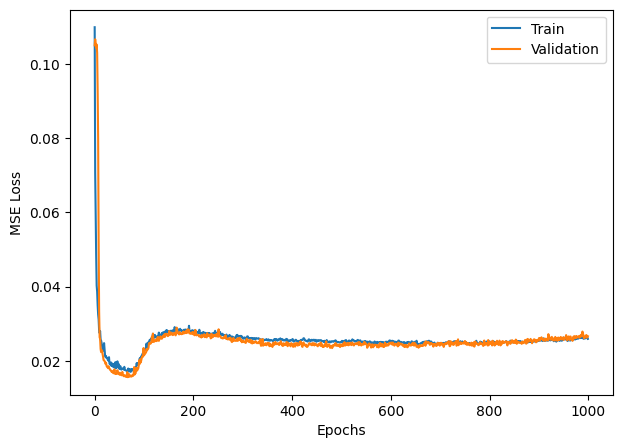

In [ ]:
new_train_lst = []
for i in range(len(train_mse)):
  new_train_lst.append(train_mse[i].cpu().detach().numpy())
new_val_lst = []
for i in range(len(val_mse)):
  new_val_lst.append(val_mse[i].cpu().detach().numpy())

plt.subplots(figsize=(7, 5))
plt.plot(new_train_lst, label = "Train")
plt.plot(new_val_lst, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/Capstone/Capstone Meeting/MSE_300_Epochs_clstm.png")
plt.show()



#Testing

In [ ]:
def test(model, test_loader):    
  model.eval()
  with torch.no_grad():
    for batch_test in test_loader:
      x_test = batch_test[:,:-1,:,:,:]
      y_test = batch_test[:,-1,:,:,:]
      if use_cuda:
        x_test, y_test, model = x_test.cuda(), y_test.cuda(), model.cuda()


      n_series_test = x_test.shape[0]
      n_img_in_series_test = x_test.shape[1]    
      img_channels_test = x_test.shape[2]
      img_height_test = x_test.shape[3]
      img_width_test = x_test.shape[4]

      x_test_new_dim = (n_series_test*n_img_in_series_test, img_channels_test, img_height_test, img_width_test)
      x_test = torch.reshape(x_test,x_test_new_dim)

      y_test_predict = model(x_test)
      y_test_crop = fn.center_crop(y_test, output_size=[256])
      y_test_predict = fn.center_crop(y_test_predict, output_size = [256])

      real_img_out = y_test_crop*255
      pred_img_out = y_test_predict*255
      
      real_img_out = real_img_out.cpu().numpy()
      pred_img_out = pred_img_out.cpu().numpy()

      real_img_out = np.moveaxis(real_img_out,1,3)
      pred_img_out = np.moveaxis(pred_img_out, 1,3)

      real_img_out = np.uint8(real_img_out)
      pred_img_out = np.uint8(pred_img_out)
      for img_num in range(real_img_out.shape[0]):

        real_out = real_img_out[img_num]
        pred_out = pred_img_out[img_num]
      
        real_out = Image.fromarray(real_out)
        pred_out = Image.fromarray(pred_out)

        real_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/lsmse"+'/'+"{:02d}".format(img_num)+'_real.jpg')
        pred_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/lsmse"+'/'+"{:02d}".format(img_num)+'_pred.jpg')
  return y_test_predict, y_test_crop

In [ ]:
img_length = 2
use_cuda = torch.cuda.is_available()
best_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/6_clstm_lsgan_final.pt"
clstm_trained = CLSTM(512)
best_condi = torch.load(best_path)
clstm_trained.load_state_dict(best_condi['generator_state_dict'])



<All keys matched successfully>

In [ ]:
gen_y_test, true_y_test = test(clstm_trained, test_dl)

In [ ]:
def test_more(model):
  model.eval()
  with torch.no_grad():
    x_arr = np.zeros(shape=(10,2,3,288,432))
    y_arr = np.zeros(shape = (10,3,288,432))
    index = 0 
    for series in range(100,110): # loop through 100 series
      for input in range(2): # loop through images within series
        model_path = "/content/drive/MyDrive/Capstone/Capstone_data_jpg/"+str(series)
        x_to_convert = Image.open(model_path+'/'+"{:02d}".format(input)+'im.jpg')
        x = np.asarray(x_to_convert)
        x = np.moveaxis(x,-1,0) # change image dimension to channel first
        x_arr[index][input] = x
      y_to_convert = Image.open(model_path+'/'+"{:02d}".format(2)+'im.jpg')
      y = np.asarray(y_to_convert)
      y = np.moveaxis(y,-1,0) # change image dimension to channel first
      y_arr[index] = y
      index+=1
    x_arr = (np.array(x_arr)/255).astype(np.float32)
    y_arr = (np.array(y_arr)/255).astype(np.float32)
    x_tor = torch.tensor(x_arr)
    y_tor = torch.tensor(y_arr)
    if use_cuda:
      x_test, y_test, model = x_tor.cuda(), y_tor.cuda(), model.cuda()


    n_series_test = x_test.shape[0]
    n_img_in_series_test = x_test.shape[1]    
    img_channels_test = x_test.shape[2]
    img_height_test = x_test.shape[3]
    img_width_test = x_test.shape[4]

    x_test_new_dim = (n_series_test*n_img_in_series_test, img_channels_test, img_height_test, img_width_test)

    x_test = torch.reshape(x_test,x_test_new_dim)

    y_test_predict = model(x_test)
    y_test_crop = fn.center_crop(y_test, output_size=[256])
    y_test_predict = fn.center_crop(y_test_predict, output_size = [256])


    real_img_out = y_test_crop*255
    pred_img_out = y_test_predict*255
    
    real_img_out = real_img_out.cpu().numpy()
    pred_img_out = pred_img_out.cpu().numpy()

    real_img_out = np.moveaxis(real_img_out,1,3)
    pred_img_out = np.moveaxis(pred_img_out, 1,3)

    real_img_out = np.uint8(real_img_out)
    pred_img_out = np.uint8(pred_img_out)
    for img_num in range(real_img_out.shape[0]):

      real_out = real_img_out[img_num]
      pred_out = pred_img_out[img_num]
    
      real_out = Image.fromarray(real_out)
      pred_out = Image.fromarray(pred_out)

      real_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/lsmse"+'/'+"{:02d}".format(img_num+10)+'_real.jpg')
      pred_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/lsmse"+'/'+"{:02d}".format(img_num+10)+'_pred.jpg')

    



In [ ]:
test_more(clstm_trained)

In [ ]:
gen_y_test_new = (gen_y_test)*255
gen_y_test_new = fn.center_crop(gen_y_test_new, output_size = [256])

tensor([0.9996, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999,
        1.0000, 0.9998, 0.9999, 0.9999, 0.9999, 1.0000, 1.0000, 0.9998, 0.9999,
        0.9984, 0.9898, 0.9981, 0.9992, 0.9998, 1.0000, 1.0000, 0.9999, 1.0000,
        0.9981, 0.9998, 0.9995, 0.9996, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998,
        0.9996, 0.9970, 0.9996, 0.9999, 0.9999, 1.0000, 0.9999, 0.9998, 0.9994,
        0.9988, 0.9997, 0.9984, 0.9999, 0.9997, 1.0000, 0.9998, 1.0000, 0.9964,
        0.9999, 0.9982, 1.0000, 1.0000, 1.0000, 0.9999, 0.9992, 0.9851, 0.9958,
        0.9999, 0.9997, 1.0000, 0.9991, 0.9990, 0.9970, 0.9972, 0.9940, 0.9993,
        0.9993, 1.0000, 0.9999, 1.0000, 0.9992, 0.9970, 0.9994, 0.9917, 0.9999,
        1.0000, 1.0000, 1.0000, 0.9999, 0.9996, 0.9995, 0.9991, 0.9999, 1.0000,
        1.0000, 1.0000, 0.9995, 0.9866, 0.9988, 0.9833, 0.9999, 1.0000, 0.9999,
        1.0000, 0.9991, 0.9984, 0.9988, 0.9931, 0.9997, 1.0000, 0.9999, 1.0000,
        0.9992, 0.9975, 0.9979, 0.9983, 

In [ ]:
gen_y_test_np = gen_y_test_new.cpu().numpy()
gen_y_test_move = np.moveaxis(gen_y_test_np,1,3)
gen_y_test_image = np.uint8(gen_y_test_move)


(10, 3, 256, 256)
(10, 256, 256, 3)


[254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 253 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 253 254 254 254 253 254 252 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 253 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 253 254 250 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254
 252 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254
 254 254 254 249 254 254 254 254 254 254 254 254 25

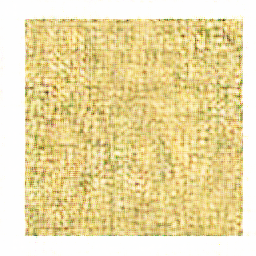

In [ ]:

transforms.ToPILImage()(gen_y_test_image[1])


[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 2

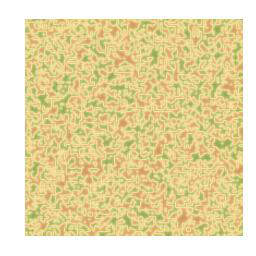

In [ ]:
# print(true_y_test[1,0,:,0])
print()
true_y_test_np = true_y_test.cpu().numpy()
true_y_test_move = np.moveaxis(true_y_test_np,1,3)
new_true_y_test = np.uint8(true_y_test_move *255)
print(new_true_y_test[1,0,:,0])
transforms.ToPILImage()(new_true_y_test[1])
# print(new_true_y_test[0,0,:,0])
# print(new_true_y_test.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


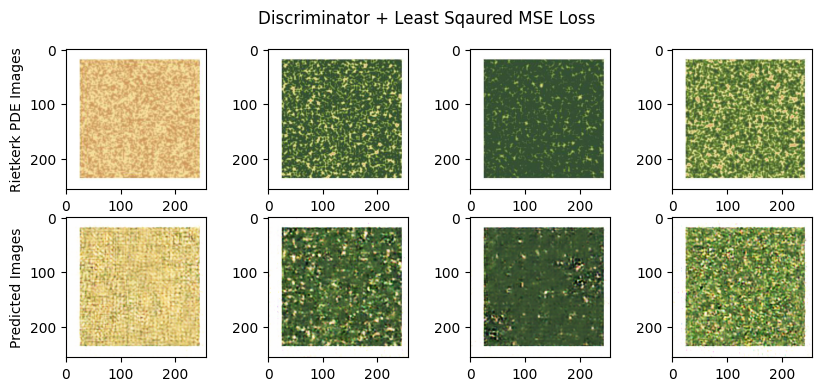

In [ ]:
f, axarr = plt.subplots(2,4,figsize=(10, 4))

img_num = 0
for img_true,img_pred in zip(new_true_y_test[3:7],gen_y_test_image[3:7]):


  print(img_true.shape)
  axarr[0,img_num].imshow(img_true)
  axarr[0,0].set_ylabel("Rietkerk PDE Images")
  axarr[1,img_num].imshow((img_pred).astype(np.uint8))
  axarr[1,0].set_ylabel("Predicted Images")

  img_num +=1
f.suptitle('Discriminator + Least Sqaured MSE Loss')
plt.show()


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


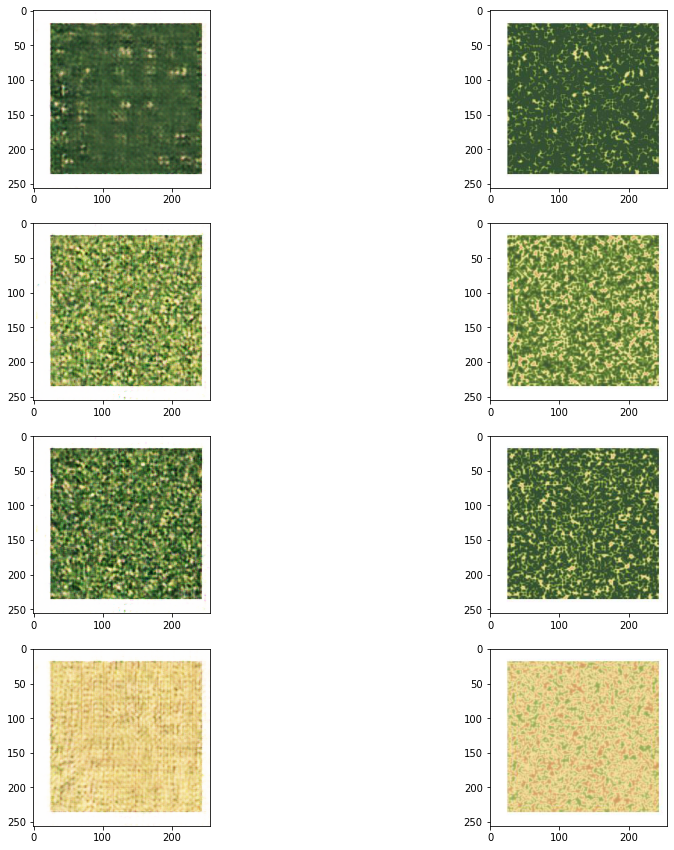

In [ ]:
f, axarr = plt.subplots(4,2,figsize=(15, 15))

img_num = 0
for img_pred, img_true in zip(gen_y_test_image[:4],new_true_y_test):
  axarr[img_num,0].imshow(img_pred)
  axarr[img_num,1].imshow(img_true)
  img_num +=1
  plt.savefig('/content/drive/MyDrive/Capstone/Capstone Meeting/clstm_lsgan_mse.png')
plt.show()